# Part 1 - Exploratory Data Analysis

### Lets create a time series plot using only matplotlib and python's standard libraries:

In [23]:
import json
from datetime import datetime, timedelta
from collections import OrderedDict
import matplotlib.pyplot as plt

In [36]:
# pandas will be used later in the notebook
import pandas as pd

In [24]:
# specify location of the json datafile
FILE_PATH = '../data/logins.json'

In [25]:
# open th json data file with context manager
with open(FILE_PATH) as json_file:
    logins = json.load(json_file)
    
    # assert data is a dictionart
    assert type(logins) == dict

In [27]:
# inspect keys
print(logins.keys())

dict_keys(['login_time'])


In [28]:
# extract login_time strings from json data
timestamps = logins['login_time']
assert type(timestamps) == list

In [29]:
# convert login timestamps to datetime objects with list comprehension
dt_timestamps = [datetime.strptime(login_time, '%Y-%m-%d %H:%M:%S') for login_time in timestamps]
assert type(dt_timestamps[0]) == datetime

In [30]:
# make sure timestamps are sorted chronologically
sorted_timestamps = sorted(dt_timestamps)

In [32]:
# create a clear and logical start date and time for aggregation
# round first timestamp down to closest 15 min
adjust_start = timedelta(minutes=sorted_timestamps[0].minute % 15, seconds=sorted_timestamps[0].second)
start = sorted_timestamps[0] - adjust_start


# create a clear and logical start date and time for aggregation
# round last timestamp up to closest 15 min
adjust_end = timedelta(minutes=((14 - sorted_timestamps[-1].minute) % 15), seconds=(60 - sorted_timestamps[-1].second))
end = sorted_timestamps[-1] + adjust_end


# define size of time intervals for aggregation
interval = timedelta(minutes=15)

In [33]:
# aggregate times into dictionary
agg_dict = OrderedDict()
window_start = start
window_end = window_start + interval
login_idx = 0
dict_vals = []

# create aggregated dict where
#   key = datetime at start of 15 min interval
#   val = list of timestamps for each login in the 15 min interval
while ((window_end <= end) and (login_idx<len(sorted_timestamps))):
    
    # check if current login is outside the current login window
    if sorted_timestamps[login_idx] > window_end:
        
        # save previous dictionary entry
        agg_dict[dict_key] = dict_vals
        
        # reset for next 15 min bucket
        window_start = window_end
        window_end = window_start + interval
        dict_vals = []
        
    else: # if sorted_timestamps[login_idx] <= window_end:
        dict_key = window_start
        dict_vals.append(sorted_timestamps[login_idx])
        login_idx += 1


In [34]:
# create counts dict where
#   key = datetime at start of 15 min interval
#   val = count of timestamped logins in the 15 min interval
counts_dict = {key: len(agg_dict[key]) for key in agg_dict.keys()}
counts_dict = OrderedDict()

for key, vals in agg_dict.items():
    counts_dict[key] = len(vals)
    
for key in sorted(agg_dict.keys()):
    counts_dict[key] = len(agg_dict[key])

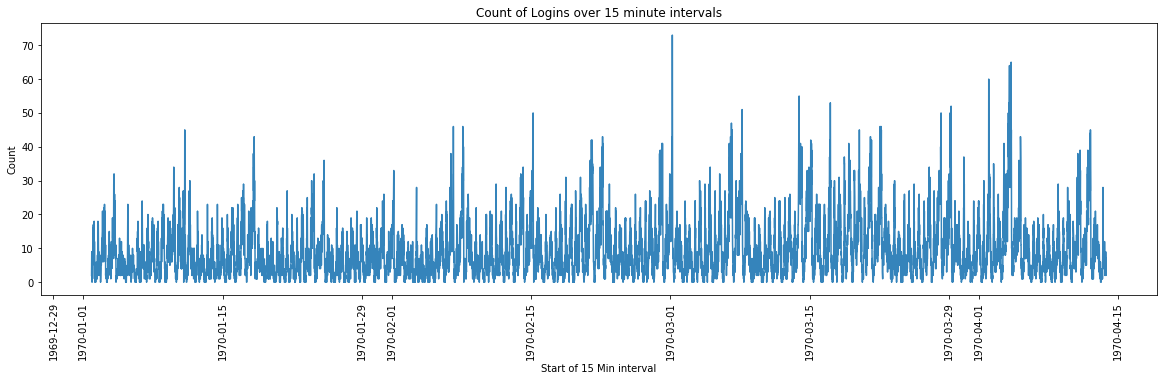

In [35]:
# mute matplotlib data warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# visualize complete time series
x = counts_dict.keys()
y = counts_dict.values()
_ = plt.figure(figsize=(20, 5))
_ = plt.plot(x, y, alpha=0.9)
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('Count of Logins over 15 minute intervals')


### The above visualization shows the counts of logins for 15 min intervals from January 01, 1970 up until April 15, 1970. The period of teh oscillations in this time series are significantly shorter than the 3.5 month frame. Examing shorter slices of the time series can provide better insight into periodic trends and behaviors. 

## First, lets recreate the above plot with pandas using only 4 lines of code

In [13]:
# read json data file with pandas
logins_df = pd.read_json(FILE_PATH)

In [14]:
# create datetime index from login_time column
logins_df.index = pd.to_datetime(logins_df.login_time)

In [15]:
# resample and aggregate with count()
resampled_df = logins_df.resample('15min').count()
resampled_df.columns = ['login_count']

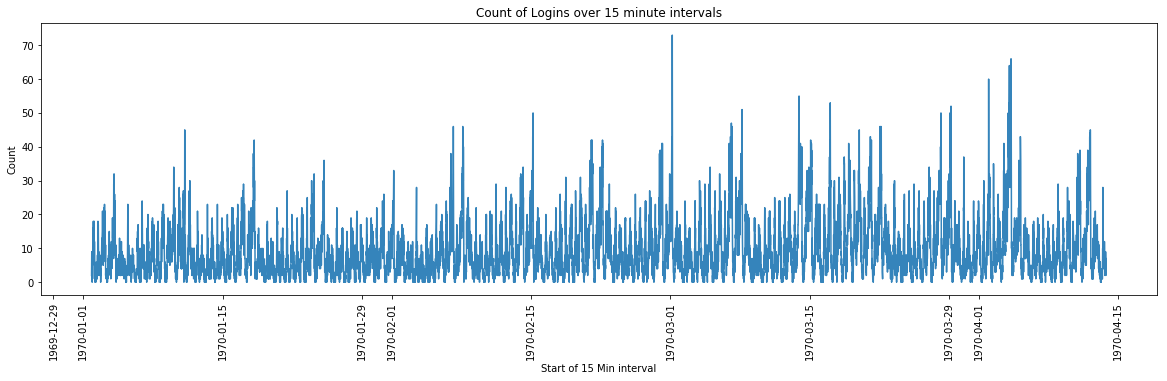

In [16]:
# visualize complete time series
_ = plt.figure(figsize=(20, 5))
_ = plt.plot(resampled_df, alpha=0.9)
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('Count of Logins over 15 minute intervals')

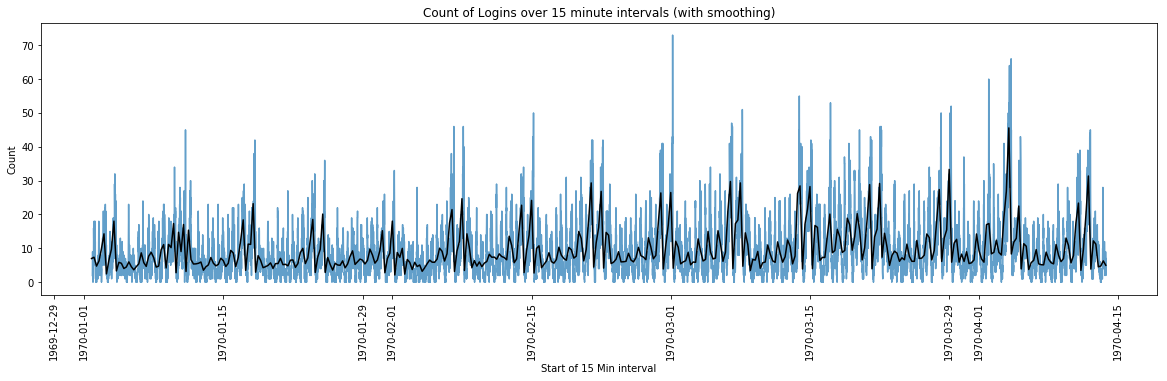

In [17]:
# this is still rough, so lets add some smoothing
hourly_df= resampled_df.resample('6H').mean()

# visualize complete time series
_ = plt.figure(figsize=(20, 5))
_ = plt.plot(resampled_df, alpha=0.7)
_ = plt.plot(hourly_df, alpha=1.0, color='k')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('Count of Logins over 15 minute intervals (with smoothing)')


### The overlayed black line applies smoothing to the original timeseries. The height of the trend line represents the mean of login counts for the previous 6 hours. 

### Let's extract each month from the above time series plot and create a visualization for each month. With a smaller slice and a 4 hour mean trendline to see if periodic patterns can be identified. 

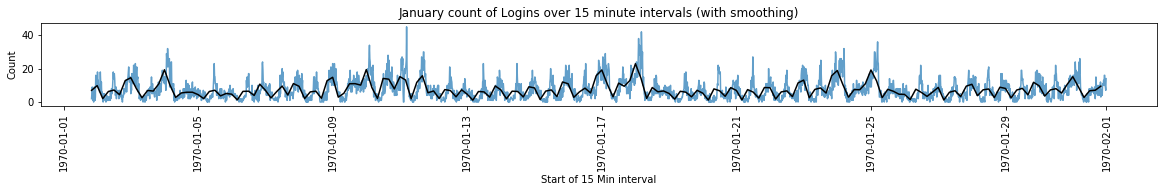

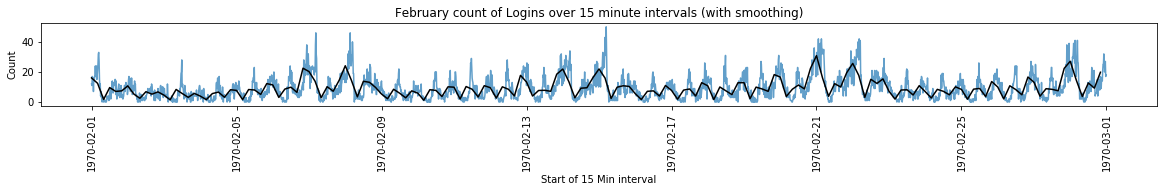

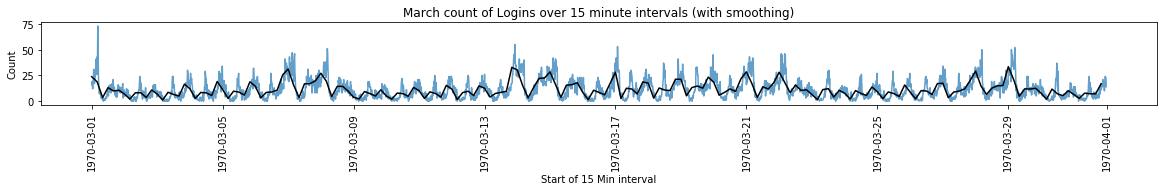

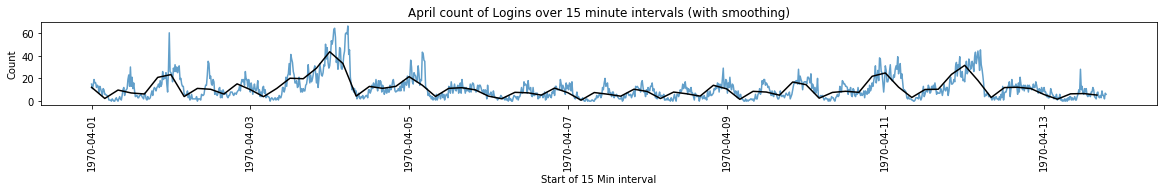

In [19]:
smooth_factor = '4H'

january = resampled_df.loc['1970-01']
jan_smoothed = january.resample(smooth_factor).mean()

february = resampled_df.loc['1970-02']
feb_smoothed = february.resample(smooth_factor).mean()

march = resampled_df.loc['1970-03']
mar_smoothed = march.resample(smooth_factor).mean()

april = resampled_df.loc['1970-04']
apr_smoothed = april.resample(smooth_factor).mean()

_ = plt.figure(figsize=(20, 7))

# visualize complete time series for January
_ = plt.subplot(4, 1, 1)
_ = plt.plot(january, alpha=0.7)
_ = plt.plot(jan_smoothed, alpha=1.0, color='k')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('January count of Logins over 15 minute intervals (with smoothing)')
plt.show()

_ = plt.figure(figsize=(20, 7))
# visualize complete time series for Febraury
_ = plt.subplot(4, 1, 2)
_ = plt.plot(february, alpha=0.7)
_ = plt.plot(feb_smoothed, alpha=1.0, color='k')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('February count of Logins over 15 minute intervals (with smoothing)')
plt.show()

_ = plt.figure(figsize=(20, 7))
# visualize complete time series for March
_ = plt.subplot(4, 1, 3)
_ = plt.plot(march, alpha=0.7)
_ = plt.plot(mar_smoothed, alpha=1.0, color='k')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('March count of Logins over 15 minute intervals (with smoothing)')
plt.show()

_ = plt.figure(figsize=(20, 7))
# visualize complete time series for April
_ = plt.subplot(4, 1, 4)
_ = plt.plot(april, alpha=0.7)
_ = plt.plot(apr_smoothed, alpha=1.0, color='k')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('April count of Logins over 15 minute intervals (with smoothing)')
plt.show()

### The above plots are still too dense and it is still too difficult to inspect significant trends and patters besides the peaks and troughs in user login behaviour.

### To inspect even smaller slices of the time series, let's recreate similar plots where each plot corresponds to one of four respective weeks in March. 

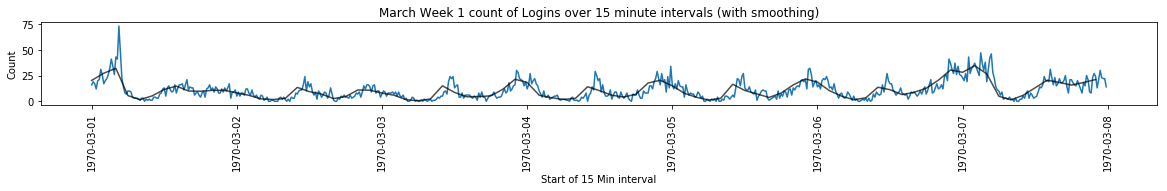

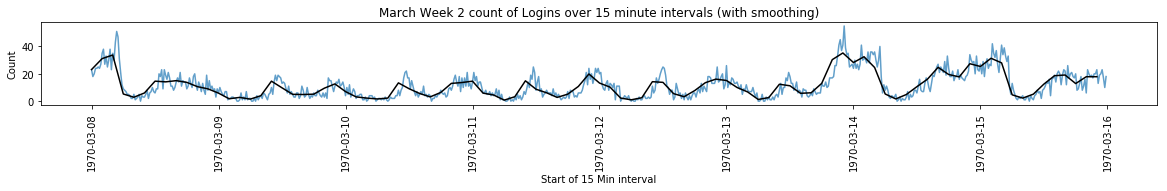

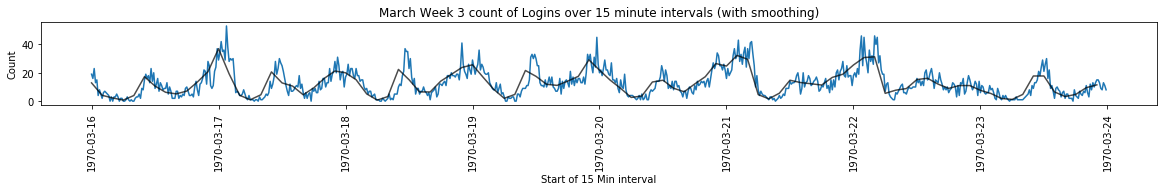

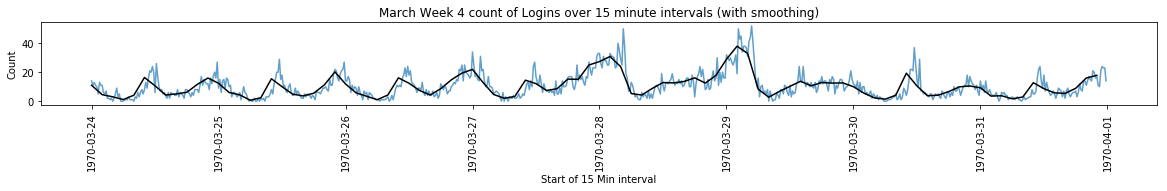

In [20]:
# still not too helpful, lets look at each week in March
smooth_factor = '2H'

week1 = resampled_df.loc['1970-03-01':'1970-03-07']
week1_smoothed = week1.resample(smooth_factor).mean()

week2 = resampled_df.loc['1970-03-08':'1970-03-15']
week2_smoothed = week2.resample(smooth_factor).mean()

week3 = resampled_df.loc['1970-03-16':'1970-03-23']
week3_smoothed = week3.resample(smooth_factor).mean()

week4 = resampled_df.loc['1970-03-24':'1970-03-31']
week4_smoothed = week4.resample(smooth_factor).mean()

_ = plt.figure(figsize=(20, 7))

# visualize complete time series for January
_ = plt.subplot(4, 1, 1)
_ = plt.plot(week1, alpha=1.0)
_ = plt.plot(week1_smoothed, alpha=0.7, color='k')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('March Week 1 count of Logins over 15 minute intervals (with smoothing)')
plt.show()

_ = plt.figure(figsize=(20, 7))
# visualize complete time series for Febraury
_ = plt.subplot(4, 1, 2)
_ = plt.plot(week2, alpha=0.7)
_ = plt.plot(week2_smoothed, alpha=1.0, color='k')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('March Week 2 count of Logins over 15 minute intervals (with smoothing)')
plt.show()

_ = plt.figure(figsize=(20, 7))
# visualize complete time series for March
_ = plt.subplot(4, 1, 3)
_ = plt.plot(week3, alpha=1.0)
_ = plt.plot(week3_smoothed, alpha=0.7, color='k')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('March Week 3 count of Logins over 15 minute intervals (with smoothing)')
plt.show()

_ = plt.figure(figsize=(20, 7))
# visualize complete time series for April
_ = plt.subplot(4, 1, 4)
_ = plt.plot(week4, alpha=0.7)
_ = plt.plot(week4_smoothed, alpha=1.0, color='k')
_ = plt.xticks(rotation=90)
_ = plt.xlabel('Start of 15 Min interval')
_ = plt.ylabel('Count')
_ = plt.title('March Week 4 count of Logins over 15 minute intervals (with smoothing)')

### continue here

### The above plots are a clear demonstration of the alternating/complementary circadian rythms. The period between each peak is 12 hours or half of a day. 

In [21]:
def avg_by_weekday(df):
    df.index = df.index.weekday_name
    df = df.groupby(['login_time']).mean()
    
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df = df.loc[weekdays]
    return df

weekday_avg = avg_by_weekday(resampled_df)

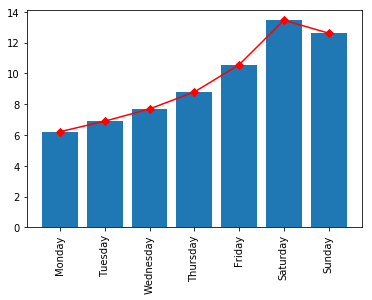

In [22]:
_ = plt.plot(weekday_avg, alpha=1, marker='D', color='r')
_ = plt.bar(weekday_avg.index, weekday_avg.login_count)
_ = plt.xticks(rotation=90)